In [0]:
!pip install -U git+https://github.com/cseveriano/fts2image@googlenet-testing

  Cloning https://github.com/cseveriano/fts2image (to revision googlenet-testing) to /tmp/pip-req-build-a3bvvgi5
Branch 'googlenet-testing' set up to track remote branch 'googlenet-testing' from 'origin'.
Switched to a new branch 'googlenet-testing'
  Running setup.py bdist_wheel for fts2image ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-jz5dbbdu/wheels/d8/4f/00/2939bfdf8fdead327ea7c1aa05ac9d0212e1639a00c1502dae
Successfully built fts2image


In [0]:
!pip install -U git+https://github.com/petroniocandido/pyFTS

  Cloning https://github.com/petroniocandido/pyFTS to /tmp/pip-req-build-obk9ox1a
  Running setup.py bdist_wheel for pyFTS ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-1hrgxv_1/wheels/84/d7/1e/a333c7128f25b347640740859808db094c4478e98663cd2297
Successfully built pyFTS


In [0]:
import pandas as pd
import os
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import pickle
from fts2image import FuzzyImageCNN

Using TensorFlow backend.


## Auxiliary Functions

In [0]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]

def calculate_rmse(test, forecast, order, step):
    rmse = math.sqrt(mean_squared_error(test.iloc[(order):], forecast[:-step]))
    print("RMSE : "+str(rmse))
    return rmse

def split_data(df, interval):
    sample_df = df.loc[interval]

    week = (sample_df.index.day - 1) // 7 + 1

    # PARA OS TESTES:
    # 2 SEMANAS PARA TREINAMENTO
    train_df = sample_df.loc[week <= 2]

    # 1 SEMANA PARA VALIDACAO
    validation_df = sample_df.loc[week == 3]

    # 1 SEMANA PARA TESTES
    test_df = sample_df.loc[week > 3]

    return (train_df, validation_df, test_df)

## Load Dataset

In [0]:
from urllib import request

#Set target and input variables 
target_station = 'DHHL_3'

#All neighbor stations with residual correlation greater than .90
neighbor_stations_90 = ['DHHL_3',  'DHHL_4','DHHL_5','DHHL_10','DHHL_11','DHHL_9','DHHL_2', 'DHHL_6','DHHL_7','DHHL_8']

dataset_path = "https://github.com/cseveriano/spatio-temporal-forecasting/raw/master/notebooks/"

request.urlretrieve(dataset_path+"df_oahu.pkl", "df_oahu")

df = pd.read_pickle("df_oahu")

# Save Min-Max for Denorm
min_raw = df[target_station].min()

max_raw = df[target_station].max()

# Perform Normalization
norm_df = normalize(df)

# Split data
interval = ((df.index >= '2010-06') & (df.index < '2010-07'))
#interval = ((df.index >= '2010-11') & (df.index <= '2010-12'))

(train_df, validation_df, test_df) = split_data(df, interval)
(norm_train_df, norm_validation_df, norm_test_df) = split_data(norm_df, interval)

## CNN Test

In [0]:
def fuzzy_cnn_forecast(train_df, test_df):
    _conv_layers = 3
    _dense_layer_neurons = 1280
    _dense_layers = 5
    _epochs = 100
    _filters = 8
    _kernel_size = 3
    _npartitions = 100
    _order = 100
    _pooling_size = 4
    _dropout = 0

    fuzzy_sets = Grid.GridPartitioner(data=train_df[target_station].values, npart=_npartitions).sets
    model = FuzzyImageCNN.FuzzyImageCNN(fuzzy_sets, nlags=_order, steps=1,
                                        conv_layers=_conv_layers, dense_layers=_dense_layers,
                                        dense_layer_neurons=_dense_layer_neurons, filters=_filters,
                                        kernel_size=_kernel_size, pooling_size=_pooling_size, dropout=_dropout)
    model.fit(train_df, epochs=_epochs, plot_images=False)

    forecast = model.predict(test_df)

    return forecast

In [0]:
steps = 1

forecast = fuzzy_cnn_forecast(norm_train_df[neighbor_stations_90], norm_test_df[neighbor_stations_90])

Epoch 1/1
754/754 [==============================] - 28s 37ms/step - loss: 0.1910


In [0]:
forecast = denormalize(forecast, min_raw, max_raw)

_order = 100

forecast.append(0) ## para manter o mesmo tamanho dos demais
rmse = calculate_rmse(test_df[target_station], forecast, _order, steps)
print("RMSE: ", rmse)

RMSE : 220.79246857647158
RMSE:  220.79246857647158


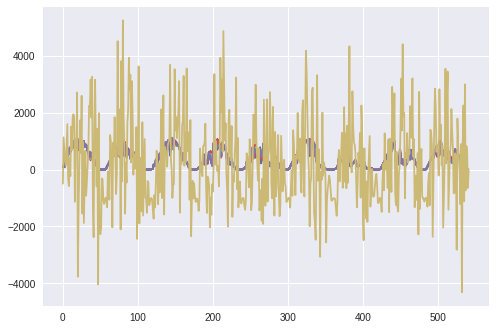

In [0]:
plt.figure()
plt.plot(test_df.iloc[_order:600].values)
plt.plot(forecast[:(600+_order)])
plt.show()